In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, PolynomialFeatures
from category_encoders import WOEEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
df = pd.read_csv("fetal_health.csv")

In [3]:
df

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.000,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.000,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.000,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000,0.000,0.007,0.000,0.0,0.0,79.0,0.2,25.0,...,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0,2.0
2122,140.0,0.001,0.000,0.007,0.000,0.0,0.0,78.0,0.4,22.0,...,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0,2.0
2123,140.0,0.001,0.000,0.007,0.000,0.0,0.0,79.0,0.4,20.0,...,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0,2.0
2124,140.0,0.001,0.000,0.006,0.000,0.0,0.0,78.0,0.4,27.0,...,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0,2.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [5]:
df.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


In [6]:
numvar = ['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance']
cat_var = ['histogram_tendency']

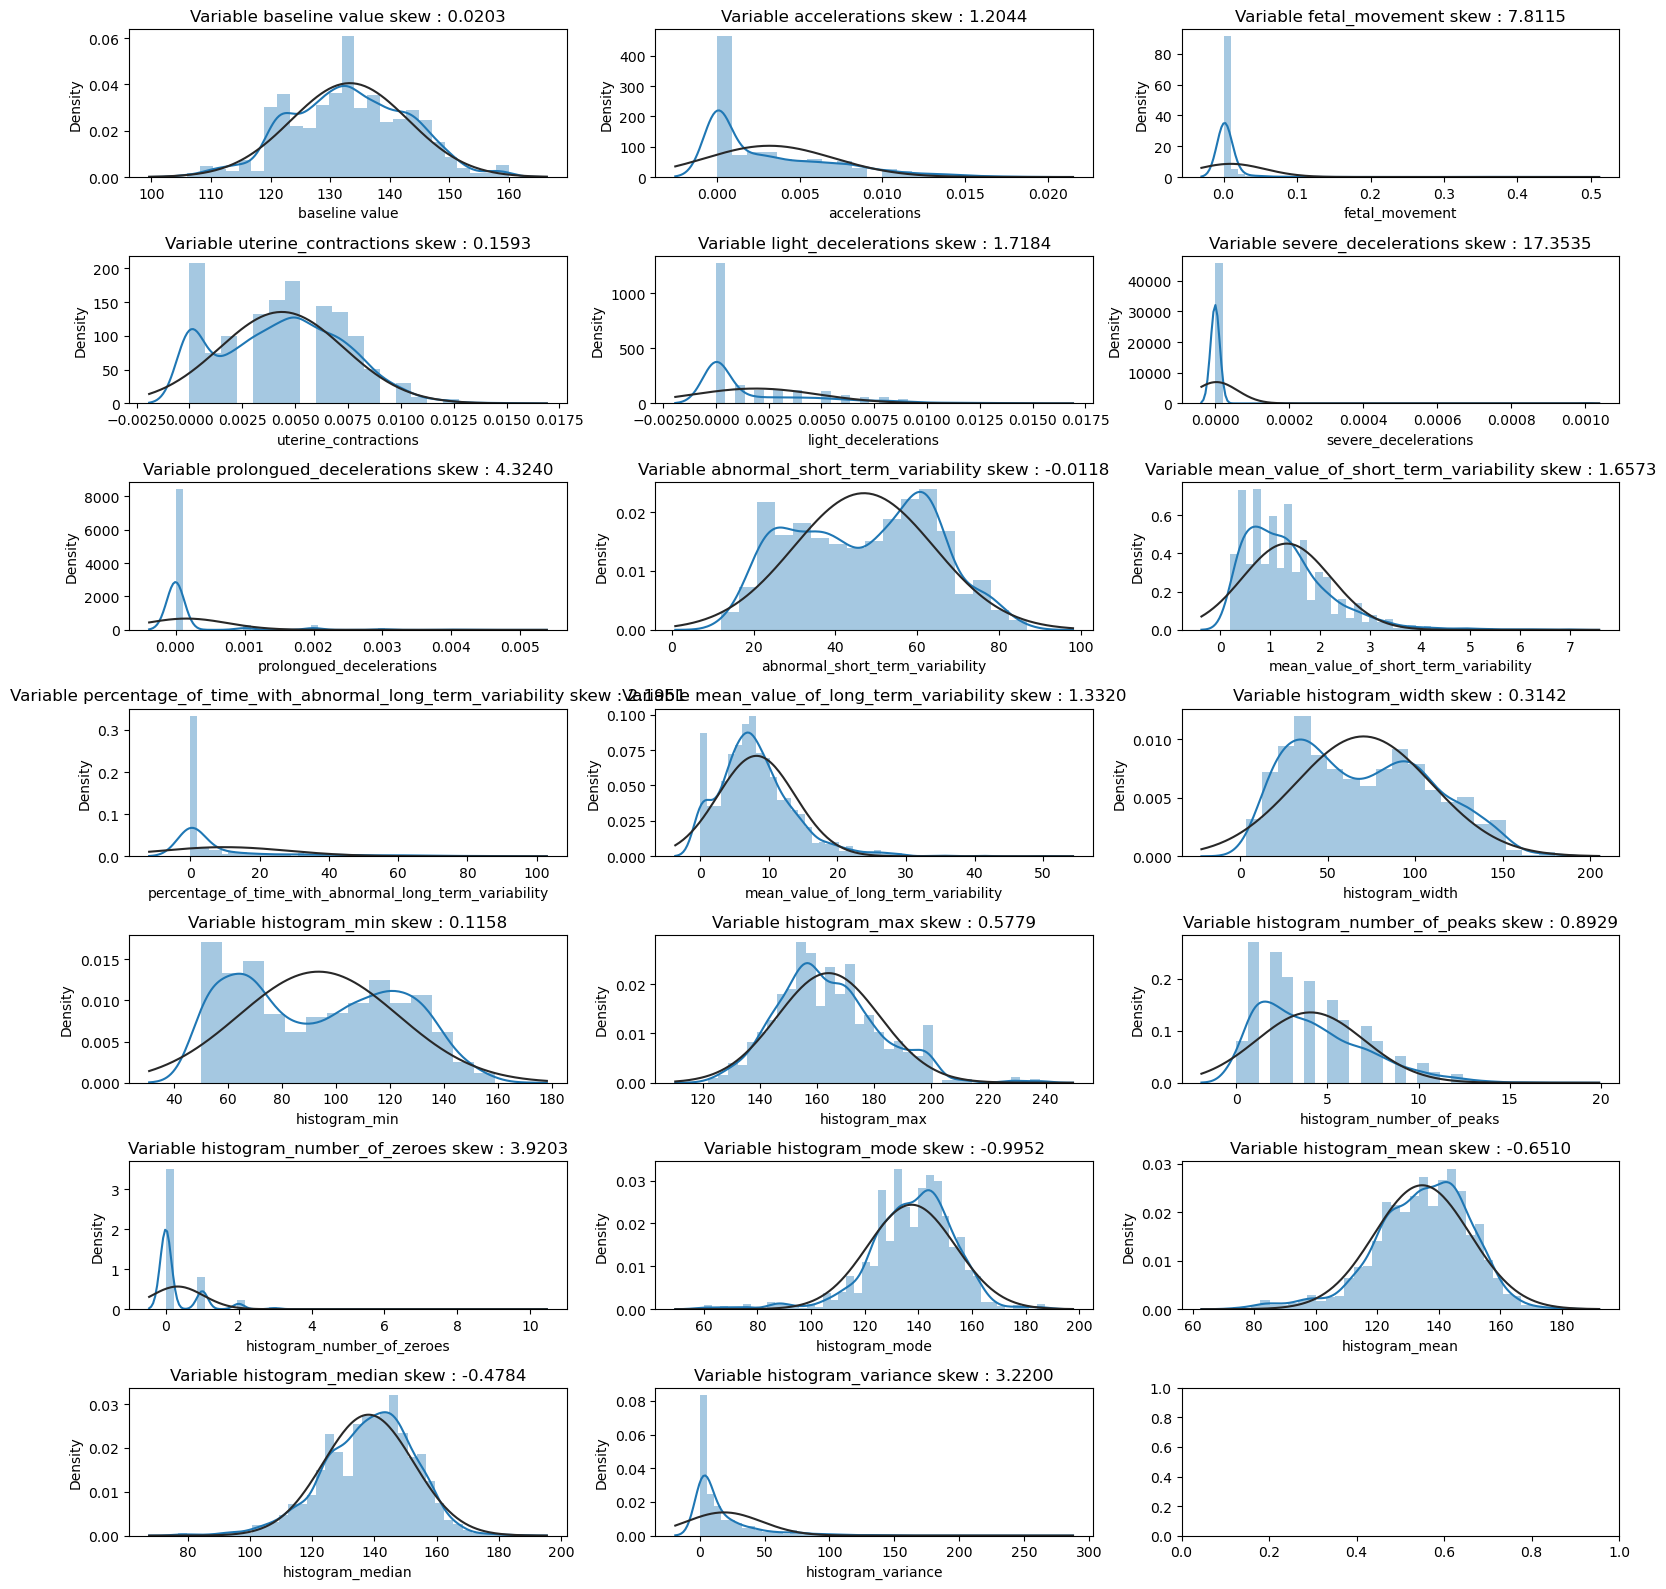

In [7]:
def con_plot(var):
    fig, ax = plt.subplots(int(np.ceil(len(numvar)/3)), 3, figsize=(16,16))
    ax = ax.flatten()
    i = 0
    for col in var:
        skew = df[col].skew()
        sns.distplot(df[col], fit = stats.norm, ax=ax[i])
        ax[i].set_title("Variable %s skew : %.4f"%(col, skew))
        i+=1
    plt.tight_layout()
    plt.show()
con_plot(numvar)

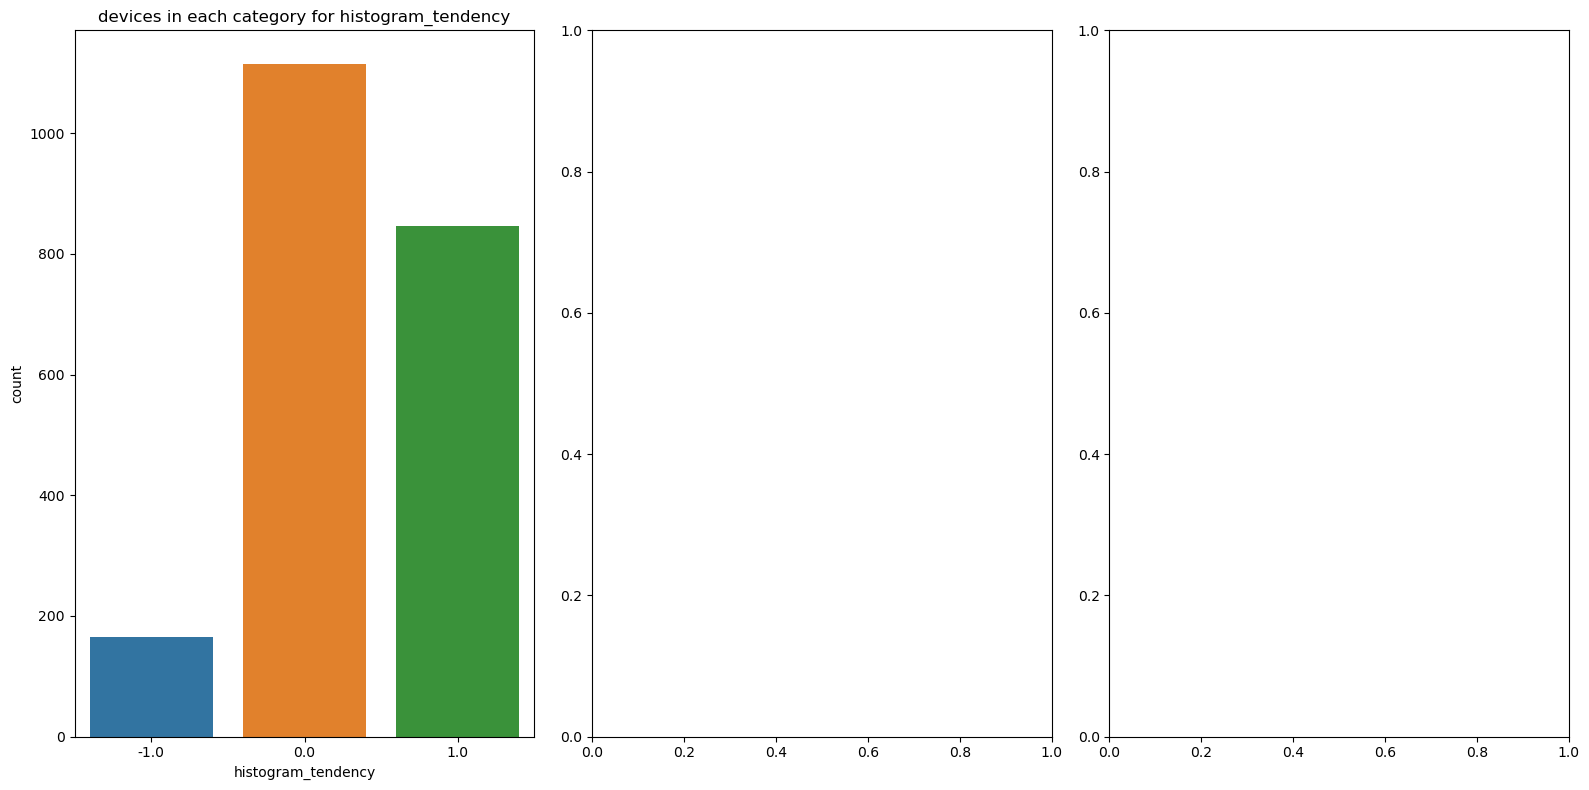

In [8]:
def cat_plot(var):
    fig, ax = plt.subplots(int(np.ceil(len(var)/3)), 3, figsize=(16,8))
    ax = ax.flatten()
    i = 0
    for col in var:
        sns.countplot(df[col], ax=ax[i])
        ax[i].set_title("devices in each category for %s"%(col))
        i+=1
    plt.tight_layout()
    plt.show()
    
cat_plot(cat_var)

In [9]:
df.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

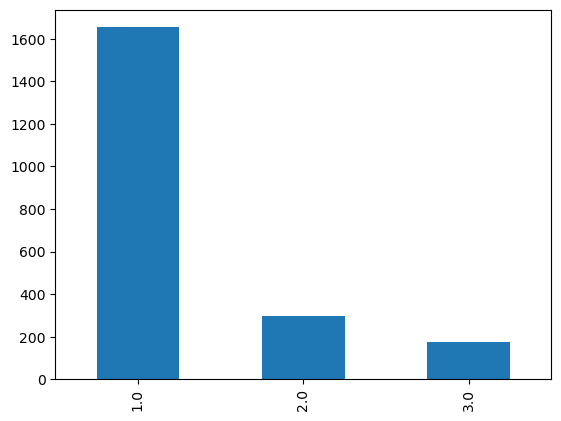

In [10]:
df.fetal_health.value_counts().plot(kind='bar')
plt.show()

In [11]:
df['fetal_health'] = df['fetal_health'].replace({1: 0, 2: 1, 3: 2})

In [12]:
X = df.drop(['fetal_health'], axis=1)
Y = df['fetal_health']

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
vif_val = pd.DataFrame({"Col":X.columns})
vif_val["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]
vif_val

,Col,VIF
0,baseline value,1058.823853
1,accelerations,4.801485
2,fetal_movement,1.184827
3,uterine_contractions,4.034365
4,light_decelerations,4.799432
5,severe_decelerations,1.136294
6,prolongued_decelerations,2.926905
7,abnormal_short_term_variability,16.051631
8,mean_value_of_short_term_variability,9.457023
9,percentage_of_time_with_abnormal_long_term_var...,2.417343


In [14]:
X = df.drop(["fetal_health",'histogram_width',
       'histogram_min', 'histogram_max','baseline value','histogram_mode','histogram_mean','histogram_median'], axis=1)
Y = df["fetal_health"]

In [15]:
numeric_var = [ 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_variance']
categ_var = ['histogram_tendency']

In [16]:
new_vif_val = pd.DataFrame({"Col":X.columns})
new_vif_val["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]
new_vif_val

,Col,VIF
0,accelerations,2.570594
1,fetal_movement,1.175490
2,uterine_contractions,3.369080
3,light_decelerations,3.558557
4,severe_decelerations,1.049056
5,prolongued_decelerations,1.911082
6,abnormal_short_term_variability,5.700483
7,mean_value_of_short_term_variability,7.479610
8,percentage_of_time_with_abnormal_long_term_var...,2.139653
9,mean_value_of_long_term_variability,3.821014


In [18]:
train, test = train_test_split(df, train_size=0.7, stratify=df.fetal_health, random_state=1)
print(f"Train data shape : {train.shape} Test data shape : {test.shape}")

Train data shape : (1488, 22) Test data shape : (638, 22)


In [19]:
x_train = train.drop(['fetal_health'], axis=1)
y_train = train.fetal_health
x_test = test.drop(['fetal_health'], axis=1)
y_test = test.fetal_health

In [20]:
model_rf = RandomForestClassifier(random_state=1, n_jobs=-1)
model_logr = LogisticRegression(random_state=1, n_jobs=-1, multi_class='multinomial')
model_lgbm = LGBMClassifier(random_state=1, n_jobs=-1)
model_xgb = XGBClassifier(random_state=1, n_jobs=-1)
model_gbr = GradientBoostingClassifier(random_state=1)
model_cat = CatBoostClassifier(random_state=1, verbose=0)

models = []
models.append(('LR',model_logr))
models.append(('RF',model_rf))
models.append(('GBR',model_gbr))
models.append(('XGB',model_xgb))
models.append(('LGB',model_lgbm))
models.append(('CAT',model_cat))

In [21]:
scaler = StandardScaler()
onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cv = StratifiedKFold(n_splits=5, random_state=1,shuffle=True)
feature = SelectFromModel(model_rf, threshold=0.001)
ct = ColumnTransformer([('onehot', onehot, categ_var),
                        ('scaler', scaler, numeric_var)], remainder='passthrough', n_jobs=-1)

In [22]:
warnings.filterwarnings("ignore")
results = []
names = []
test_accuracies = []  # Lista para armazenar as acurácias nos dados de teste

for name, model in models:
    pipe = Pipeline([('ct', ct), (name, model)])
    
    # Realiza a validação cruzada no conjunto de treinamento
    scores = cross_val_score(pipe, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    
    names.append(name)
    results.append(scores)
    
    print("Model %s - CV accuracy: %.4f ± %.4f" % (name, np.mean(scores), np.std(scores)))
    
    # Treina o modelo nos dados de treinamento
    pipe.fit(x_train, y_train)
    
    # Avalia o modelo nos dados de teste
    test_accuracy = pipe.score(x_test, y_test)
    test_accuracies.append(test_accuracy)
    print("Model %s - Test accuracy: %.4f" % (name, test_accuracy))

/home/samuelmapurunga/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/samuelmapurunga/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Model LR - CV accuracy: 0.8582 ± 0.0098
Model LR - Test accuracy: 0.8668
Model RF - CV accuracy: 0.9308 ± 0.0125
Model RF - Test accuracy: 0.9467
Model GBR - CV accuracy: 0.9382 ± 0.0121
Model GBR - Test accuracy: 0.9530
Model XGB - CV accuracy: 0.9368 ± 0.0177
Model XGB - Test accuracy: 0.9530
Model LGB - CV accuracy: 0.9435 ± 0.0154
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1200
[LightGBM] [Info] Number of data points in the train set: 1488, number of used features: 22
[LightGBM] [Info] Start training from score -0.250739
[LightGBM] [Info] Start training from score -1.972469
[LightGBM] [Info] Start training from score -2.493004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [23]:
warnings.filterwarnings("ignore")

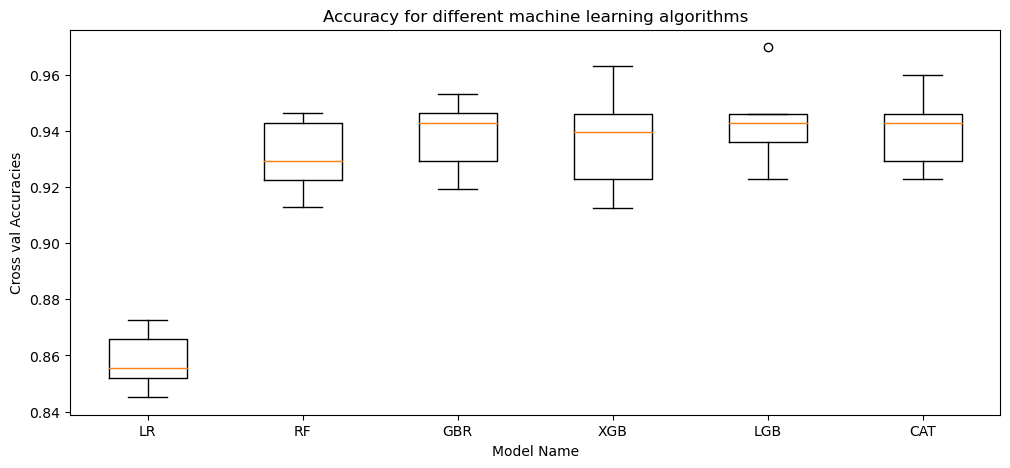

In [24]:
plt.figure(figsize=(12,5))
plt.boxplot(results)
plt.xticks(np.arange(1,len(names)+1),names)
plt.title("Accuracy for different machine learning algorithms")
plt.xlabel("Model Name")
plt.ylabel("Cross val Accuracies")
plt.show()